In [3]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [6]:
import os
os.chdir("../..")
os.getcwd()

'/Users/Kangyu/Documents/GitHub/Gesture-Nauts'

In [1]:
dataset = 'model/fine_tune_keypoint_classifier/keypoint.csv'
classes_path = 'model/fine_tune_keypoint_classifier/keypoint_classifier_label.csv'
model_save_path = 'model/fine_tune_keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/fine_tune_keypoint_classifier/keypoint_classifier.tflite'

In [4]:
# Set number of classes
NUM_CLASSES = 18

# Dataset reading

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter
from collections import OrderedDict
# stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, stratify=y_dataset, random_state=RANDOM_SEED)
# print the number of labels in each set
train_counter = OrderedDict(sorted(Counter(y_train).items()))
test_counter = OrderedDict(sorted(Counter(y_test).items()))
print("Train set:", train_counter)
print("Test set:", test_counter)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [8]:
classes = np.loadtxt(classes_path, delimiter=',', dtype='str')

In [9]:
print(X_train.shape, y_train.shape)

(6003, 42) (6003,)


# Model building

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Layer, Input, Add,Conv2D, MaxPooling2D,Reshape
from tensorflow.keras import Model
# model = tf.keras.models.Sequential([
#     Input((21 * 2, )),
#     Dense(256, activation='relu'),
#     Dense(512, activation='relu'),
#     Dense(1024, activation='relu'),
#     Dense(1024, activation='relu'),
#     Dropout(0.2),
#     Dense(NUM_CLASSES, activation='softmax')
# ])
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten

class ResidualBlock(Layer):
    def __init__(self, units, dropout_rate=0.2, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate
        self.dense1 = Dense(units, activation='relu')
        self.bn1 = BatchNormalization()
        self.dropout1 = Dropout(dropout_rate)
        self.dense2 = Dense(units, activation='relu')
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.bn2(x)
        if inputs.shape[-1] == self.units:
            x = Add()([inputs, x])  # Add skip connection only if dimensions match
        return x

    def get_config(self):
        config = super(ResidualBlock, self).get_config()
        config.update({
            "units": self.units,
            "dropout_rate": self.dropout_rate
        })
        return config


# model = Sequential([
#         Input(shape=(21 * 2,)),
#         Dense(256, activation='relu'),
#         Dropout(0.3),
#         ResidualBlock(256, dropout_rate=0.3),
#         ResidualBlock(512, dropout_rate=0.3),
#         ResidualBlock(1024, dropout_rate=0.3),
#         ResidualBlock(1024, dropout_rate=0.3),
#         Dense(NUM_CLASSES, activation='softmax')
#     ])

model = Sequential([
    Input(shape=(21 * 2, )),
    Reshape((21, 2)),
    Conv1D(64, kernel_size=3, activation='relu', padding='same', ),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    
    MaxPooling1D(pool_size=2),
    Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    Conv1D(256, kernel_size=3, activation='relu', padding='same'),

    
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.1),
    Dense(NUM_CLASSES, activation='softmax')
])

2024-04-30 08:45:42.650150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 08:45:42.712837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:
2024-04-30 08:45:42.712888: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-04-30 08:45:42.714511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimi

In [11]:
# NUM_CLASSES = 10  # Example, change this to your actual number of classes
# model = build_model(21 * 2, 10)
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 21, 2)             0         
                                                                 
 conv1d (Conv1D)             (None, 21, 64)            448       
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 64)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 128)           0         
 1D)                                                    

In [12]:
# Model checkpoint callback
log_path="model/fine_tune_keypoint_classifier/log"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
logs_path = "model/fine_tune_keypoint_classifier/log"
if not os.path.exists(log_path):
    os.mkdir(log_path)
cm_callback = tf.keras.callbacks.TensorBoard(
            log_dir=logs_path,
            update_freq='batch',
            profile_batch=0)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=100, verbose=1)

In [13]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model training

In [14]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=2048,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, cm_callback, es_callback]
)

Epoch 1/1000


3/3 [==============================] - ETA: 0s - loss: 2.8780 - accuracy: 0.0611
Epoch 1: saving model to model/fine_tune_keypoint_classifier/keypoint_classifier.hdf5
3/3 [==============================] - 2s 346ms/step - loss: 2.8780 - accuracy: 0.0611 - val_loss: 2.8201 - val_accuracy: 0.0830
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 2.7744 - accuracy: 0.0785
Epoch 2: saving model to model/fine_tune_keypoint_classifier/keypoint_classifier.hdf5
3/3 [==============================] - 1s 223ms/step - loss: 2.7744 - accuracy: 0.0785 - val_loss: 2.7364 - val_accuracy: 0.0645
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 2.7216 - accuracy: 0.1001
Epoch 3: saving model to model/fine_tune_keypoint_classifier/keypoint_classifier.hdf5
3/3 [==============================] - 1s 219ms/step - loss: 2.7216 - accuracy: 0.1001 - val_loss: 2.6438 - val_accuracy: 0.1594
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 2.6213 - accuracy:

In [15]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/16 [>.............................] - ETA: 0s - loss: 0.4043 - accuracy: 0.8750

16/16 [==============================] - 0s 9ms/step - loss: 0.4780 - accuracy: 0.8501


In [7]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [8]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

NameError: name 'X_test' is not defined

# Confusion matrix

63/63 [==============================] - 0s 5ms/step


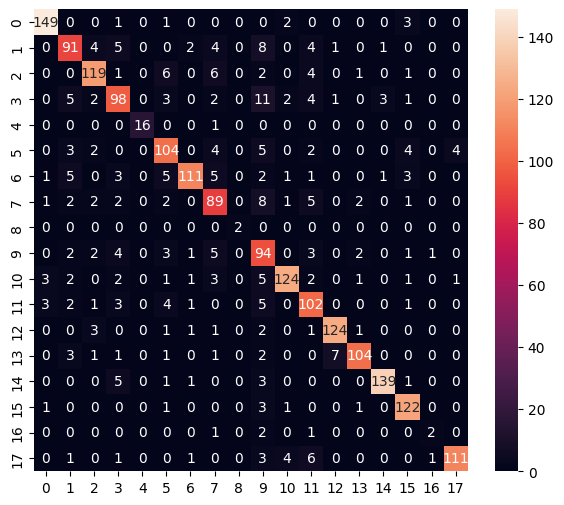

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       156
           1       0.78      0.76      0.77       120
           2       0.88      0.85      0.86       140
           3       0.78      0.74      0.76       132
           4       1.00      0.94      0.97        17
           5       0.78      0.81      0.80       128
           6       0.93      0.80      0.86       138
           7       0.73      0.77      0.75       115
           8       1.00      1.00      1.00         2
           9       0.61      0.80      0.69       118
          10       0.92      0.85      0.88       146
          11       0.76      0.84      0.79       122
          12       0.93      0.93      0.93       134
          13       0.93      0.87      0.90       120
          14       0.97      0.93      0.95       150
          15       0.88      0.95      0.91       129
          16       0.50      0.33      0.40         6
     

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [19]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [9]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/d2/m407fqx579b1pd1qn49j010m0000gn/T/tmp8fdmx5ek/assets


INFO:tensorflow:Assets written to: /var/folders/d2/m407fqx579b1pd1qn49j010m0000gn/T/tmp8fdmx5ek/assets
2024-05-09 21:07:33.633386: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-09 21:07:33.635248: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


1955056

# Inference test

In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [22]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [23]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [24]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 4.29 ms, sys: 163 µs, total: 4.45 ms
Wall time: 39.4 ms


In [25]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.9498592e-09 1.5868747e-16 5.5391830e-15 1.5058420e-09 4.9799373e-22
 4.6947799e-04 2.9833103e-17 1.8179751e-14 4.1014780e-24 4.3217601e-06
 3.2970046e-03 3.7559339e-12 3.9814574e-13 1.4789878e-10 8.7650655e-08
 5.2892585e-07 1.1509392e-07 9.9622846e-01]
17
